# Proyecto Final: Selección de Modelo en Modo Secuencial

_Jorge III Altamirano Astorga, Luz Aurora Hernández Martínez, Ita-Andehui Santiago Castillejos._

Se realizaron pruebas de los 3 tipos de neuronas:

1. [DNN](proyectofinal03a_dnn_sinaica.html)

2. [RNN](proyectofinal03b_rnn_sinaica.html)

3. [LSTM](proyectofinal03c_lstm_sinaica.html)

4. [Convolucional](proyectofinal03d_conv1d_sinaica.html)

Procederemos a evaluarlo.

In [1]:
import dill, os, io, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, display_markdown, Markdown
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
models = []
object_names = []
for y in [x for x in os.listdir("models-sinaica") if x.endswith("dill")]:
    with io.open(f"models/{y}", 'rb') as file:
        object_name = re.sub(r"\.", "_", y)
        object_name = re.sub(r"_dill", "", object_name)
        globals()[object_name] = dill.load(file)
        object_names.append(object_name)
        
Markdown("Objetos cargados: \n\n>" + 
         ", ".join(object_names))

Objetos cargados: 

>model_dnn01_hist, model_dnn03_time, model_baseline01_hist, model_dnn01_time, model_lstm03_time, model_lstm01_hist, model_baseline01_time, model_lstm01_time, model_lstm03_hist, model_conv03_hist, model_conv01_hist, model_conv03_time, model_conv01_time, model_dnn03_hist, model_rnn03_hist, model_rnn03_time, model_rnn01_time, model_rnn01_hist

In [3]:
sinaica = pd.read_pickle("data/sinaica/sinaica-imputated.pickle.gz")
sinaica.head(3)

,CO,NO,NO2,NOx,O3,PM10,PM2.5,SO2,month,day,hour,datetime,minute,temperature,pressure,humidity,gasResistance,IAQ
987,2.2,0.205,0.031,0.207,0.002,45.0,22.0,0.004,2,12,6,2021-02-12 06:05:35.846304417,35.0,21.51,777.41,44.04,152149.0,34.7
988,2.2,0.205,0.031,0.207,0.002,45.0,22.0,0.004,2,12,6,2021-02-12 06:05:38.837326527,34.0,21.51,777.41,43.98,152841.0,33.6
989,2.2,0.205,0.031,0.207,0.002,45.0,22.0,0.004,2,12,6,2021-02-12 06:05:47.812360048,32.0,21.54,777.41,43.73,153259.0,31.5


## Gráficas de Desempeño

### Gráficas de Desempeño de Todas las Épocas

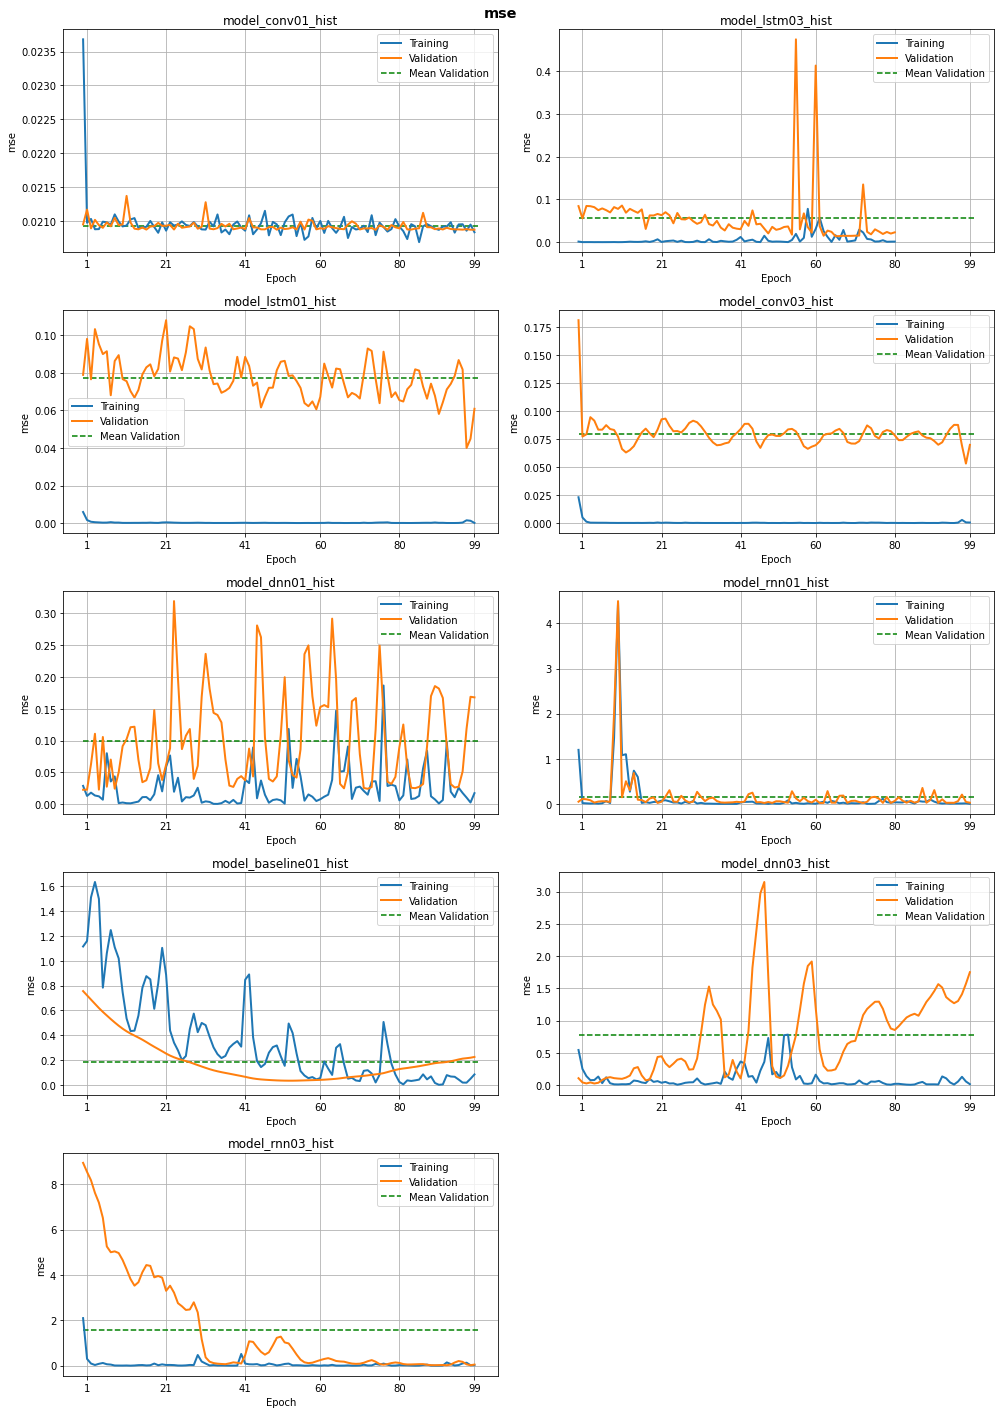

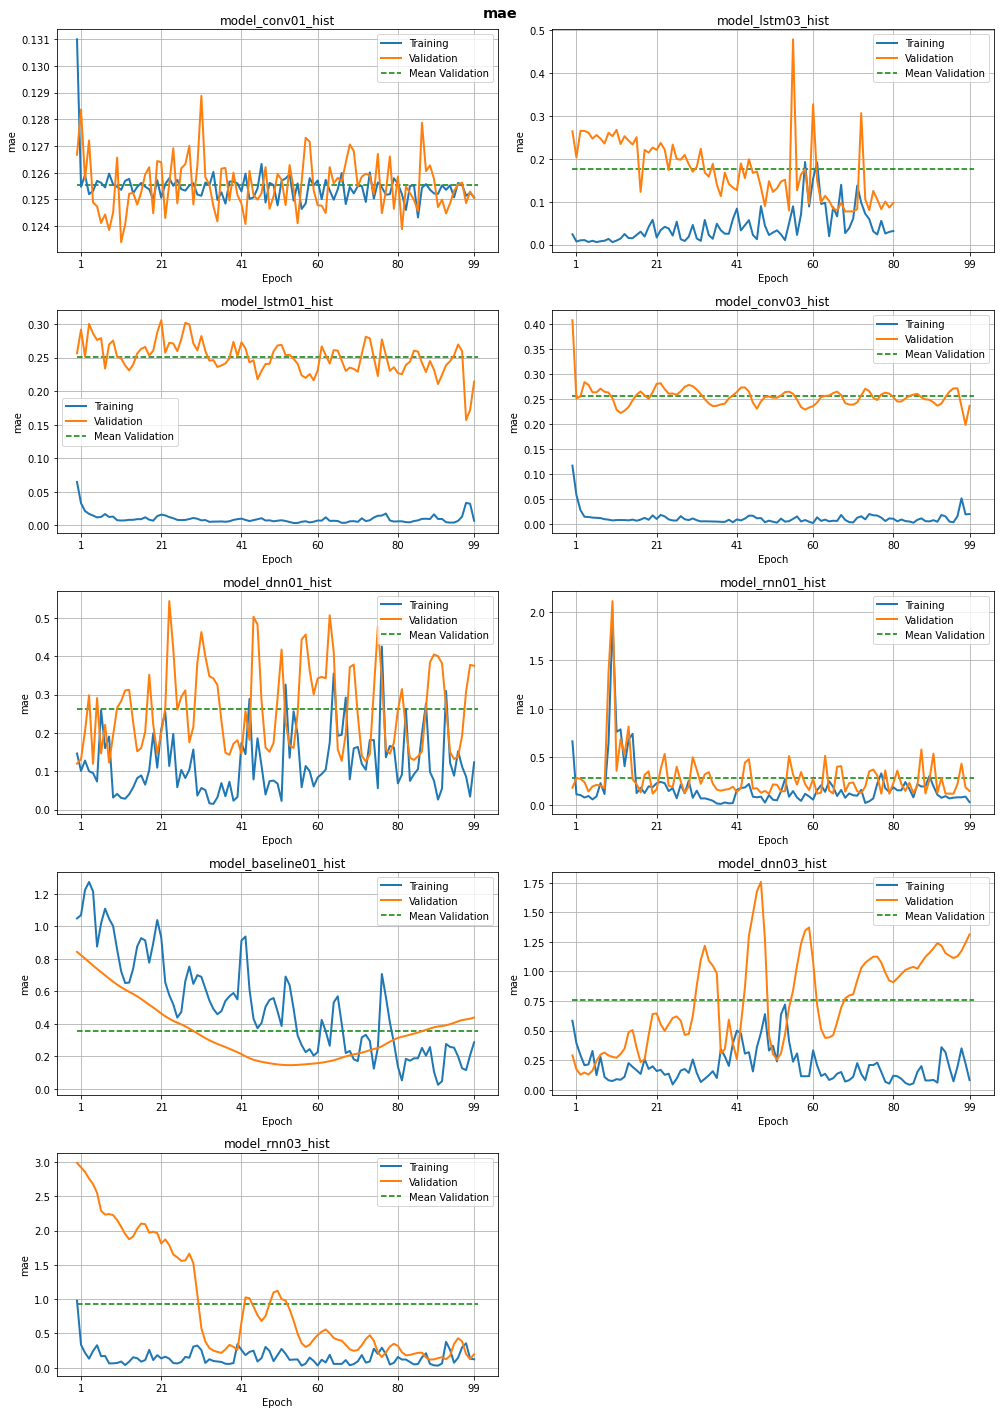

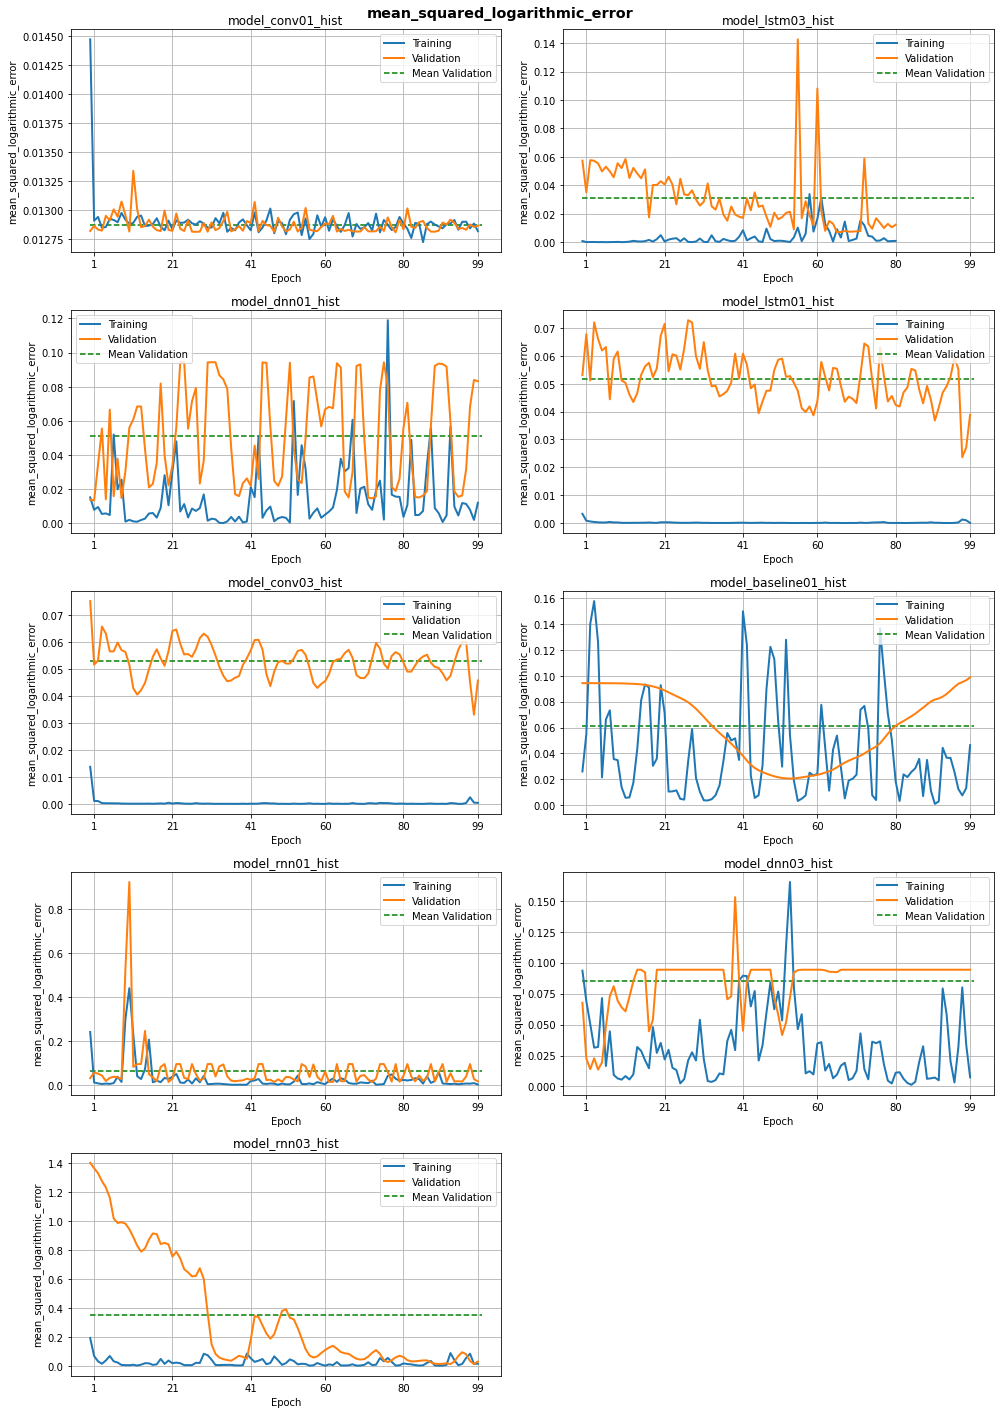

In [4]:
def models_plot(histories, a=None, b=None, 
                    metric='loss',
                    plot_validation=True):
  """
  Prints performance plot from a, to b on a list with object names in strings:
  i.e., ["model00", "model01", "modelltsm00", ..]
  
  Inputs:
  histories: an array with dicts containing the metrics key
  a: epoch start
  b. last epoch
  metric: plot this metric.
  plot_validation: boolean indicating if validation data should be plotted.
  a: from this epoch
  b: to this epoch    
  """
  
  """
  # Plot loss
  plt.subplot(imgrows, 2, 1)
  plt.title('Loss')
  plt.plot(history['loss'][a:b], label='Training', linewidth=2)
  if plot_validation:
    plt.plot(history['val_loss'][a:b], label='Validation', linewidth=2)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(f'Loss')
  ### quantiles
  plt.xticks(ticks=quantiles-a,
              labels=quantiles)
  plt.grid(True)

  # Plot accuracy
  """
  models = [globals()[h] for h in histories]
  max_epochs = np.max([len(o[metric]) for o in models])
  if a is None:
      a = 0
  if b is None:
      b = max_epochs
  a = np.min((a,b))
  b = np.max((a,b))
  #print(f"a={a}, b={b}")
  
  imgrows = (len(histories)) / 2.
  imgrows = np.round(imgrows + .1, 0)
  imgrows = int(imgrows) #+ 1
  #print(f"length={len(histories)}")
  #print(f"imgrows={imgrows}")
  
  # x ticks
  quantiles = np.quantile(range(a, b), 
                          [.2, .4, .6, .8]).round(0).astype(int)
  quantiles = np.insert(quantiles, 0, [a])
  quantiles += 1
  quantiles = np.append(quantiles, [b-1])
  
  if plot_validation:
    model_order = {h: np.mean(v["val_" + metric]) for h, v in zip(histories, models)}
  else:
    model_order = {h: np.mean(v[metric]) for h, v in zip(histories, models)}
  model_order = {m: model_order[m] for m in sorted(model_order, 
                                                   key=model_order.get)}
  
  # init the plot
  plt.figure(figsize=(14., 4.*imgrows), frameon=False, tight_layout=True)
  plt.suptitle(metric, va='top', weight='bold', size='x-large')
  # create plot for every model
  #for i, (model_name, model) in enumerate(zip(histories, models)): 
  for i, (model_name) in enumerate(model_order.keys()):
    model = globals()[model_name]
    
    plt.subplot(imgrows, 2, i+1)
    plt.title(model_name)
    if plot_validation:
      mean_label="Mean Validation"
    else:
      mean_label="Mean Training"
    plt.hlines(y=model_order[model_name], xmin=0, linestyles="dashed",
               xmax=b-a, label=mean_label, color="green")
    plt.plot(model[metric][a:b], label='Training', 
              linewidth=2)
    if plot_validation:
      plt.plot(model["val_" + metric][a:b], 
                label='Validation', linewidth=2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.xticks(ticks=quantiles-a, 
                labels=quantiles)
    plt.grid(True)

  plt.show()
  
model_histories = [o 
                   for o in object_names 
                   if o.endswith("_hist")
                  ]
model_metrics = [k 
                 for k in globals()[model_histories[0]].keys()
                 if re.search("^(val_|loss)", k) is None
                ]
for model_metric in model_metrics:
  models_plot(model_histories, metric=model_metric)

### Gráficas de Desempeño de las Últimas Épocas

Graficamos a continuación de la época 90 a la 100, siendo esta la última época.

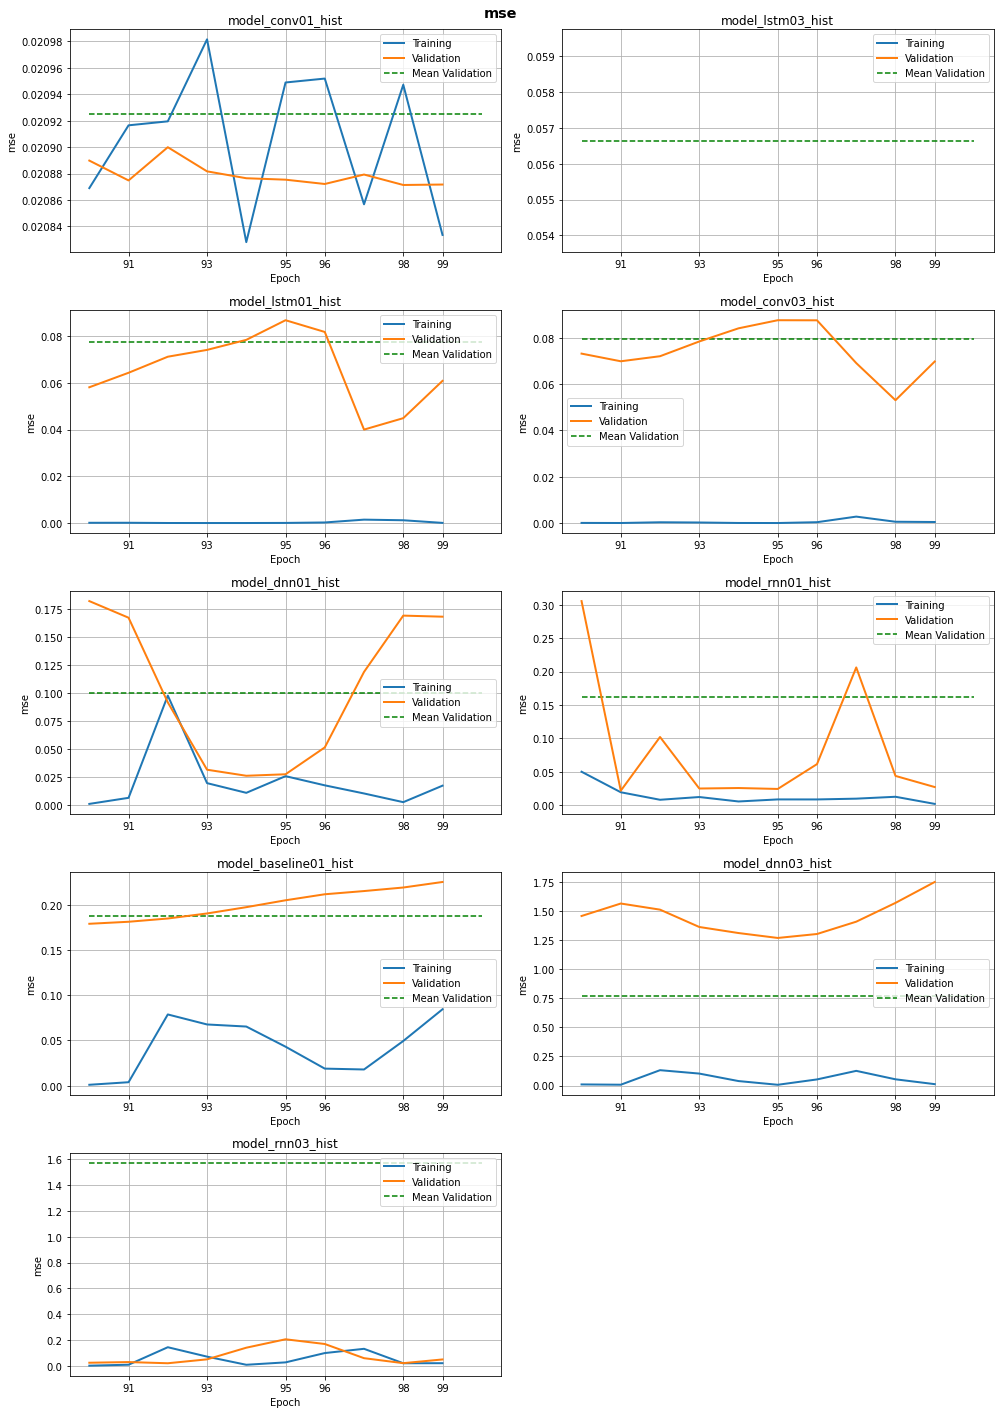

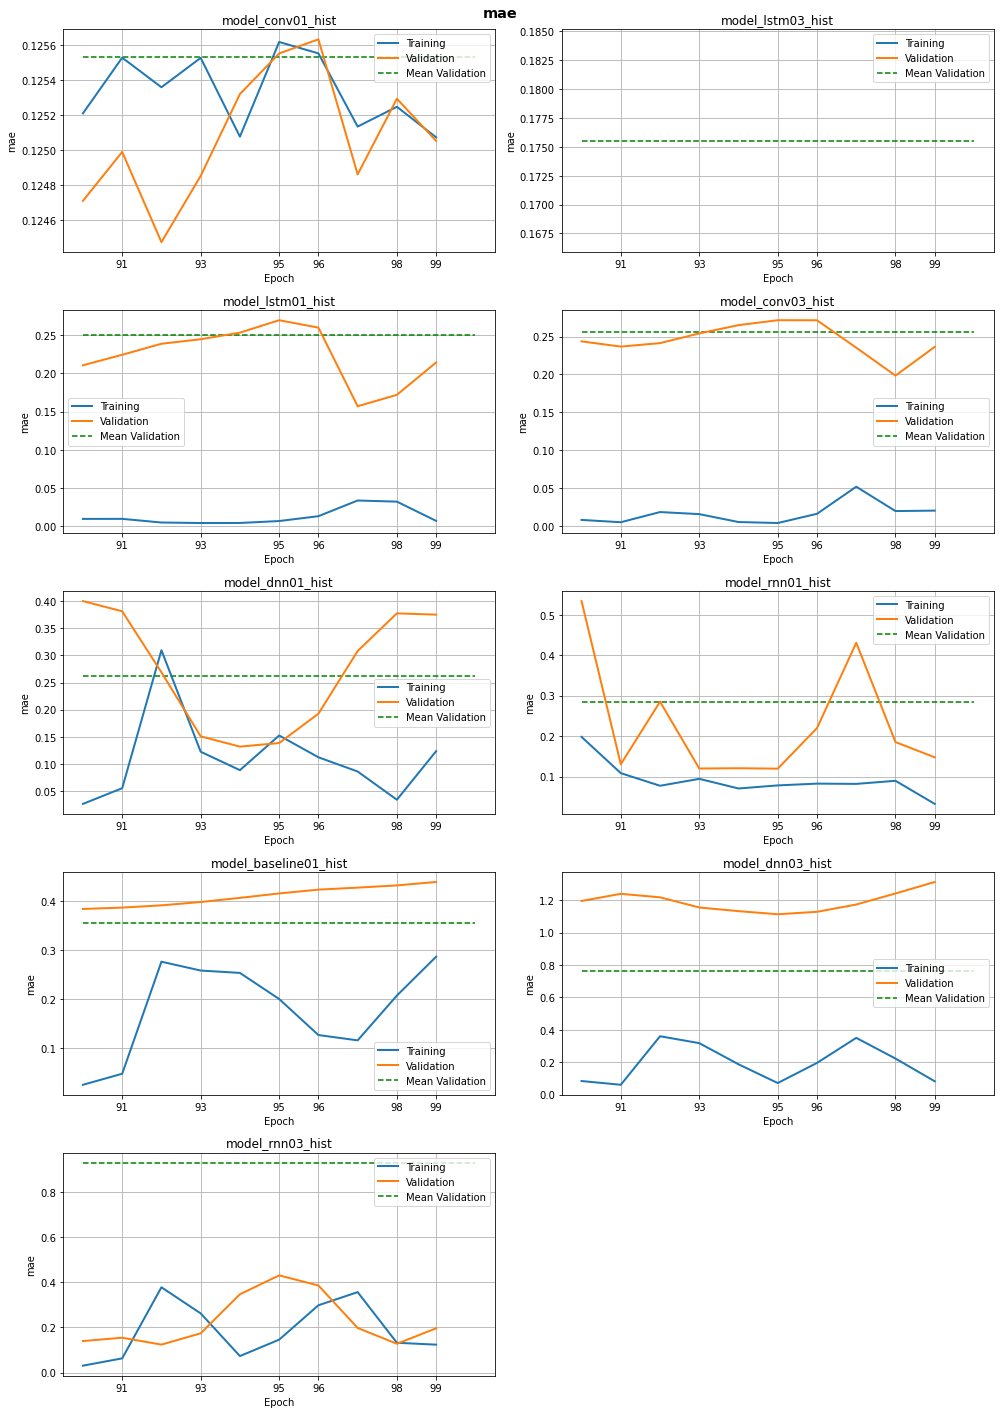

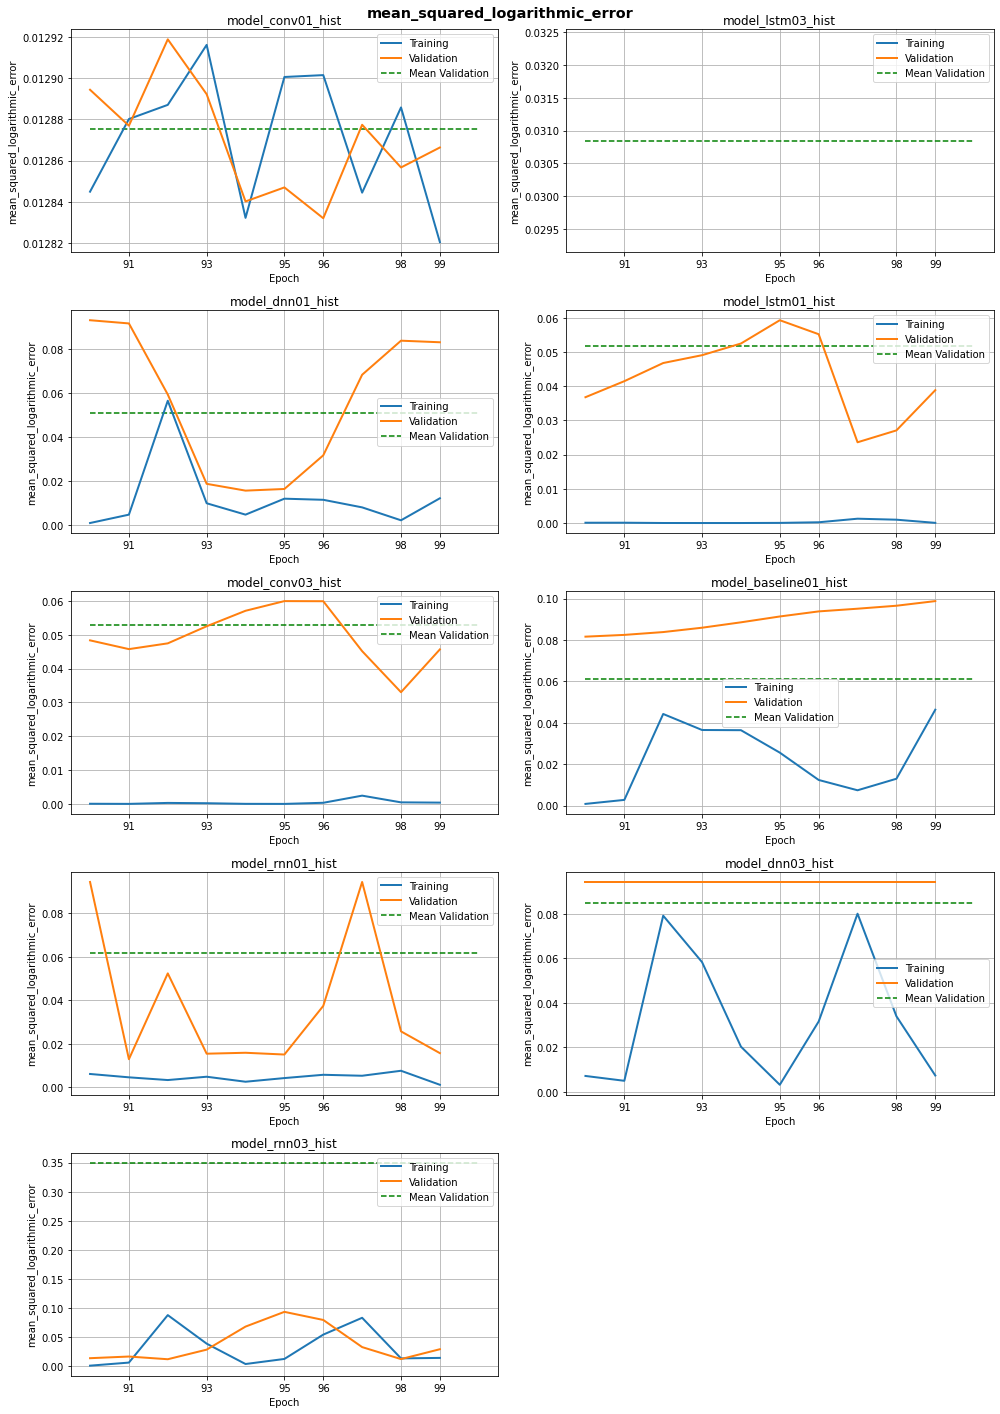

In [5]:
for model_metric in model_metrics:
  models_plot(model_histories, metric=model_metric, a=90)

## Tabla Comparativa

A continuación presentaremos una tabla con los resultados. Pero antes
presentaremos brevemente la descripción de la columnas:

* Modelo: Nomobre del modelo. 

    * model_lstmXX: Long Term Short Memory. 
    
    * model_convXX: Convex 1D.
    
    * model_rnn: Recurrent Neural Network.
 
 * Tiempo: valores en minutos (m), segundos (s).
 

 * mse, val_mse: valores de la función de peŕdida Error Cuadrático Medio (Mean Squared Error). 
 Esta es la métrica que utilizamos para ajustar el backprop.
 
 * mae, val_mae: valores de la métrica "Error Absoluto Medio" (Mean Absolute Error).
 
 * msle, val_msle: valores de la métrica Error Cuadrático Logarítmico Medio (Mean Squared Logarithmic Error).
 
 La tabla ha sido ordenada del menor valor (mejor) en la función de pérdida: mse.

In [6]:
model_times = [o for o in object_names if o.endswith("_time")]
perf_table = pd.DataFrame({
  "Modelo": [re.sub("_time$", "", model_time) for model_time in model_times],
  "Tiempo": [globals()[model_time] for model_time in model_times]
})
for metric in model_metrics:
  perf_table["val_" + metric] = [np.mean(globals()[o]["val_" + metric]) for o in model_histories]
for metric in model_metrics:
  perf_table[metric] = [np.mean(globals()[o][metric]) for o in model_histories]
perf_table.rename({
  "mean_squared_logarithmic_error": "msle",
  "val_mean_squared_logarithmic_error": "val_msle"
}, axis=1, inplace=True)
perf_table.drop(["loss", "val_loss"], axis=1, inplace=True, errors='ignore')
perf_table.sort_values("val_mse", inplace=True)
perf_table["Tiempo"] = (perf_table["Tiempo"] // 60).astype('int').astype("str") + "m" + \
(perf_table["Tiempo"] % 60).round(3).apply(lambda x: f"{x:2.2f}") + "s"
perf_table.reset_index(inplace=True, drop=True)
perf_table.round(4)

,Modelo,Tiempo,val_mse,val_mae,val_msle,mse,mae,msle
0,model_conv03,6m33.58s,0.0209,0.1255,0.0129,0.0209,0.1255,0.0129
1,model_baseline01,0m57.19s,0.0566,0.1755,0.0308,0.0061,0.0434,0.0035
2,model_lstm03,9m11.55s,0.0774,0.2508,0.0518,0.0002,0.0100,0.0002
3,model_lstm01,1m40.80s,0.0796,0.2556,0.0529,0.0005,0.0116,0.0003
4,model_dnn03,4m13.19s,0.0998,0.2628,0.0512,0.0255,0.1225,0.0148
5,model_rnn01,7m56.31s,0.1625,0.2845,0.0616,0.1330,0.1840,0.0278
6,model_dnn01,1m40.90s,0.1877,0.3550,0.0614,0.3653,0.5150,0.0413
7,model_conv01,14m3.57s,0.7706,0.7625,0.0849,0.0925,0.2030,0.0313
8,model_rnn03,7m32.10s,1.5727,0.9295,0.3496,0.0659,0.1529,0.0225


### Valores de Desempeño Quitándoles Escalamiento

A continuación aplicamos la operación inversa del `MinMaxScaler()`, por lo que las métricas de desempeño serán en la escala verdadera.

Para los modelos con números impares, como model_MMMM03, son para la variable `IAQ`. La cual tiene un rango de valores de la siguiente manera:

In [7]:
Markdown(f"min IAQ: {sinaica['IAQ'].min():3,.2f}; " + \
f"max IAQ: {sinaica['IAQ'].max():3,.2f}")

min IAQ: 0.00; max IAQ: 500.00

Recordando que lo que queremos predecir es la escala internacional IAQ, mostraremos los modelos IAQ.

In [8]:
sinaica = pd.read_pickle("data/sinaica/sinaica-imputated.pickle.gz")
excluded_columns = ["iaqAccuracy", "datetime", "datetime-1", "delta", 
                    "imputated", "year"]
train, test = train_test_split(sinaica[[x 
                                        for x in sinaica.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.8, random_state=175904, shuffle=False)
scaler_iaq = MinMaxScaler().fit(train[["IAQ"]])
perf_data_iaq = scaler_iaq.inverse_transform(perf_table.select_dtypes("float64"))
#scaler_gr = MinMaxScaler().fit(train[["gasResistance"]])
#perf_data_gr = scaler_gr.inverse_transform(perf_table.select_dtypes("float64"))
perf_data_iaq = pd.DataFrame(perf_data_iaq, 
                             columns=perf_table.select_dtypes("float64").columns)
#perf_data_gr  = pd.DataFrame(perf_data_gr, 
#                             columns=perf_table.select_dtypes("float64").columns)
perf_data_iaq.insert(0, "Tiempo", perf_table["Tiempo"], )
#perf_data_gr.insert(0,  "Tiempo", perf_table["Tiempo"], )
perf_data_iaq.insert(0, "Modelo", perf_table["Modelo"], )
#perf_data_gr.insert(0,  "Modelo", perf_table["Modelo"], )
perf_data = perf_table.copy()
perf_data.sort_values("val_mse", inplace=True)
perf_data.reset_index(inplace=True, drop=True)
model_number_rows = [int(re.sub("[^0-9]", "", x)) for x in perf_table["Modelo"]]
#is_gr_row = [(x % 2) == 0 for x in model_number_rows]
is_iaq_row = [(x % 2) == 1 for x in model_number_rows]
#perf_data.iloc[is_gr_row] = perf_data_gr
perf_data.iloc[is_iaq_row] = perf_data_iaq
cols = ["Modelo", "Tiempo", "val_mae", "mae"]
perf_data.round(2)[cols]

,Modelo,Tiempo,val_mae,mae
0,model_conv03,6m33.58s,56.80,56.77
1,model_baseline01,0m57.19s,79.43,19.65
2,model_lstm03,9m11.55s,113.49,4.54
3,model_lstm01,1m40.80s,115.64,5.24
4,model_dnn03,4m13.19s,118.93,55.45
5,model_rnn01,7m56.31s,128.75,83.27
6,model_dnn01,1m40.90s,160.65,233.04
7,model_conv01,14m3.57s,345.03,91.86
8,model_rnn03,7m32.10s,420.61,69.18


# Referencias

* Román-Rangel, Francisco. Notas y Código del Curso de Aprendizaje Profundo. 2021.

* González-Pérez, Felipe. [Notas de aprendizaje de máquina](https://lucid-torvalds-517e78.netlify.app/). 2020.

* Keras contributors et al. [Keras / Code examples / Timeseries / Timeseries forecasting for weather prediction](https://keras.io/examples/timeseries/timeseries_weather_forecasting/). 2021.

* Tensorflow Contributors. [Tensorflow: Tutorial on Time series forecastingTime series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_serieshttps://www.tensorflow.org/tutorials/structured_data/time_series). 2021.
 
* Mohd, Faizy. [StackOverflow AI: How to use CNN for making predictions on non-image data?](https://ai.stackexchange.com/a/10449). 2021.

* Ondris, Ladislav. [StackOverflow: How to apply CNN algorithm in python for non image dataset.](https://stackoverflow.com/a/64326002/7323086) 2020.

* [Shady, Slim. Convolutional Neural Network With Tensorflow and Keras](https://medium.com/geekculture/introduction-to-convolutional-neural-network-with-tensorflow-and-keras-cb52cdc66eaf). 2021.

* Keras contributors et al. [Keras API Reference: fit](https://keras.rstudio.com/reference/fit.html). 2021.

* Keras contributors et al. [Keras API Reference: Convolution Layers > Convolution1D](https://keras.io/api/layers/convolution_layers/convolution1d/). 2021.

* Pedregosa, Fabian; et al. [Scikit-learn: Machine Learning in Python](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 2021.

* Abadi, Martín, et al. [TensorFlow: Large-scale machine learning on heterogeneous systems](https://tensorflow.org). 2015. 

* McKinney, Wes. [Data structures for statistical computing in python](https://conference.scipy.org/proceedings/scipy2010/pdfs/mckinney.pdf). 2010.

* Harris, Charles, et al. Array programming with NumPy. 2021. [doi:10.1038/s41586-020-2649-2](https://doi.org/10.1038/s41586-020-2649-2)

* Hunter, John. Matplotlib: A 2D Graphics Environment. 2007. [doi:10.5281/zenodo.592536/zenodo.592536](https://doi.org/10.5281/zenodo.592536https://doi.org/10.5281/zenodo.592536)